In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu124
0.19.0+cu124


## 1. Getting a dataset

* Download and load FashionMNIST data


In [4]:
# Setup training data and test data
train_data = datasets.FashionMNIST(
    root = "data",
    train= True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train= False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)



In [7]:
len(train_data), len(test_data)

(60000, 10000)

In [16]:
image, label = train_data[0]

In [14]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [15]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [17]:
image.shape, class_names[label]

(torch.Size([1, 28, 28]), 'Ankle boot')

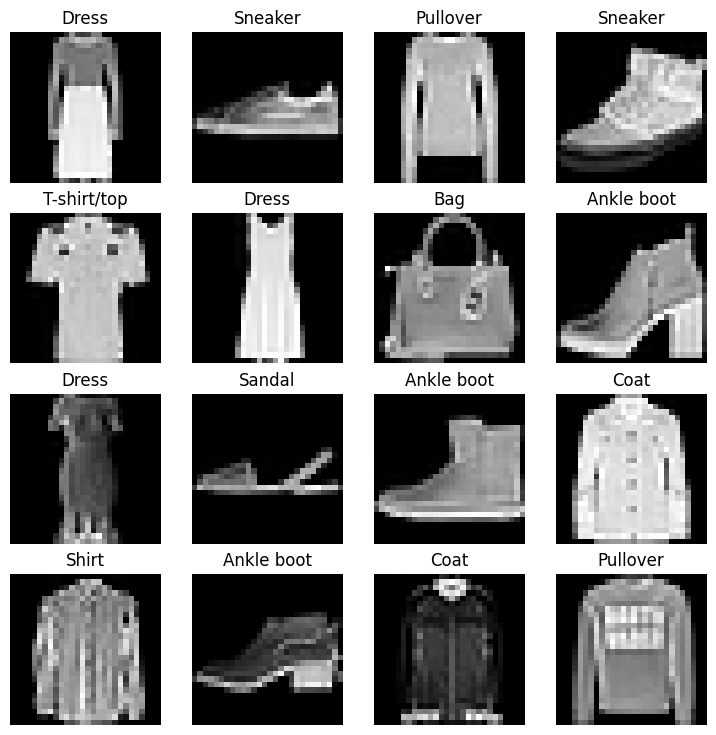

In [28]:
# Visualizing our data
#torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows,cols, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [30]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)


In [31]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001E4532E7BF0>, <torch.utils.data.dataloader.DataLoader object at 0x000001E4538E2CC0>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [34]:
train_features_batch, train_label_batch = next(iter(train_dataloader))
train_features_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

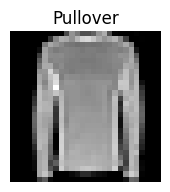

In [38]:
# Visualizing our data
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_label_batch[random_idx]
fig.add_subplot(rows,cols, i)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

In [41]:
# Model: Build a baseline model
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x) #perform flatten pass

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [46]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,input_shape, hidden_units, output_shape=10):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, X):
        return self.layer_stack(X)

model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names))
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [48]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x).shape

torch.Size([1, 10])

In [50]:
from torchmetrics import Accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.01)
accuracy = Accuracy(task='multiclass', num_classes=10 )

In [54]:
from timeit import default_timer as timer
def print_train_time(start,
                    end,
                    device=None):
    """ Print difference between start and end time"""
    total_time = end -start
    print(f"Train time on {device} : {total_time} seconds")
    return total_time

In [55]:
start = timer()
end = timer()
print_train_time(start,end)

Train time on None : 5.759997293353081e-05 seconds


5.759997293353081e-05

In [56]:
# creating a training loop and training a model on batches of data
#1) loop through epochs
# loop through batches, perform training steps, calculate the train loss per batch
# 3) loop through test batches, perform testing steps, calculate the test loss per batch
# 4) time it all

In [59]:
from tqdm.auto import tqdm

In [61]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

#creating training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")
    ### Training
    train_loss =0
    # Add a loop to loop through training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        #2. Calculate loss (per batch)
        loss = loss_fn(y_pred,y)
        train_loss +=loss # accumulate train loss

        #3 optimizer zero grad
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch %400 ==0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /=len(train_dataloader)

    #Testing
    test_loss,test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss +=loss_fn(test_pred, y_test)
            test_acc +=accuracy(test_pred.argmax(dim=1), y_test)

        test_loss /=len(test_dataloader)
        test_acc /=len(test_dataloader)

    print(f"Train loss: {train_loss :.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                           end = train_time_end_on_cpu)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|████████████████████████████                                                        | 1/3 [00:09<00:18,  9.18s/it]

Train loss: 0.5649 | Test loss: 0.5102 | Test acc: 0.82
Epoch: 1
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:17<00:08,  8.97s/it]

Train loss: 0.5020 | Test loss: 0.4905 | Test acc: 0.83
Epoch: 2
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.95s/it]

Train loss: 0.4829 | Test loss: 0.5523 | Test acc: 0.81
Train time on None : 26.866834399988875 seconds


In [84]:
#Make predictions and get model results
def eval_model(model,
              data_loader,
              loss_fn,
              accuracy_fn,
              device = device):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss,acc =0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss +=loss_fn(y_pred, y)
            acc +=accuracy_fn(y_pred.argmax(dim=1),y)
        loss /=len(data_loader)
        acc /=len(data_loader)
    return {"model_name":model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc": acc.item()*100}

In [86]:
model_0_results = eval_model(model_0,test_dataloader,loss_fn,accuracy,"cpu")
model_0_results

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 198.81it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5523344874382019,
 'model_acc': 81.13018870353699}

In [71]:
device="cuda"

In [72]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape, hidden_units, output_shape=10):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, X):
        return self.layer_stack(X)

model_1 = FashionMNISTModelV0(input_shape=784, 
                              hidden_units=10, output_shape=len(class_names)).to(device)
model_1

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [73]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [79]:
from torchmetrics import Accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr = 0.01)
accuracy = Accuracy(task='multiclass', num_classes=10 ).to(device)

In [105]:
#let's create a function for 
# training loop - train_step()
#testing loop - test_step()

def train_step(model, dataloader, loss_fn, optimizer, accuracy, device=device):
    """Performs a training with a model trying to learn on data loader"""
    train_loss, train_acc =0,0
    #model.to(device)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        #2. Calculate loss (per batch)
        loss = loss_fn(y_pred,y)
        train_loss +=loss # accumulate train loss
        train_acc +=accuracy(y_pred.argmax(dim=1), y)

        #3 optimizer zero grad
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            

    train_loss /=len(dataloader)
    train_acc /=len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}")


def test_step(model, dataloader, loss_fn, optimizer, accuracy, device=device):
    #Testing
    test_loss,test_acc = 0,0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            test_loss +=loss_fn(y_pred, y)
            test_acc +=accuracy(y_pred.argmax(dim=1), y)

        test_loss /=len(dataloader)
        test_acc /=len(dataloader)

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")
    

In [82]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 3

#creating training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")
    train_step(model_1,train_dataloader,loss_fn,optimizer,accuracy,device)
    test_step(model_1,test_dataloader,loss_fn,optimizer,accuracy,device)
    
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu,
                                           end = train_time_end_on_gpu,
                                           device=device)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Train loss: 0.4794 | Train acc: 0.83


 33%|████████████████████████████                                                        | 1/3 [00:17<00:34, 17.42s/it]

Test loss: 0.4958 | Test acc: 0.83
Epoch: 1
----
Train loss: 0.4769 | Train acc: 0.84


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:34<00:17, 17.30s/it]

Test loss: 0.4914 | Test acc: 0.83
Epoch: 2
----
Train loss: 0.4644 | Train acc: 0.84


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:51<00:00, 17.17s/it]

Test loss: 0.5510 | Test acc: 0.82
Train time on cuda : 51.52701409999281 seconds


In [87]:
model_1_results = eval_model(model_1,test_dataloader,loss_fn,accuracy,device)
model_1_results

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 142.75it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5510474443435669,
 'model_acc': 81.52955174446106}

In [106]:
# Create a convolution neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates TinyVGG
    model from CNN explainer website.
    """

    def __init__(self, input_shape,hidden_units,output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*49, out_features=output_shape),
        )

    def forward(self,X):
        return self.classifier(self.conv_block_2(self.conv_block_1(X)))


model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10,
                             output_shape=len(class_names)).to(device)
model_2
        

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [107]:
torch.manual_seed(42)
images = torch.randn(size=(32,3,64,64))
test_image = images[0]
test_image.shape

torch.Size([3, 64, 64])

In [97]:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                        kernel_size=3,
                      stride=1,
                      padding=1)
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

In [98]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pool_output = max_pool_layer(conv_output)
max_pool_output.shape

torch.Size([10, 32, 32])

In [108]:
from torchmetrics import Accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr = 0.01)
accuracy = Accuracy(task='multiclass', num_classes=10 ).to(device)

In [109]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 3

#creating training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")
    train_step(model_2,train_dataloader,loss_fn,optimizer,accuracy,device)
    test_step(model_2,test_dataloader,loss_fn,optimizer,accuracy,device)
    
train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_on_gpu,
                                           end = train_time_end_on_gpu,
                                           device=device)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Train loss: 0.5332 | Train acc: 0.80


 33%|████████████████████████████                                                        | 1/3 [00:23<00:46, 23.32s/it]

Test loss: 0.4181 | Test acc: 0.85
Epoch: 1
----
Train loss: 0.4079 | Train acc: 0.85


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:49<00:24, 24.90s/it]

Test loss: 0.3938 | Test acc: 0.85
Epoch: 2
----
Train loss: 0.3912 | Train acc: 0.86


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:15<00:00, 25.30s/it]

Test loss: 0.3962 | Test acc: 0.85
Train time on cuda : 75.91161480010487 seconds


In [110]:
model_2_results = eval_model(model_2,test_dataloader,loss_fn,accuracy,device)
model_2_results

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.01it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3961966931819916,
 'model_acc': 85.33346652984619}

In [111]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5523344874382019,
 'model_acc': 81.13018870353699}

In [112]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,model_1_results,model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.552334,81.130189
1,FashionMNISTModelV0,0.551047,81.529552
2,FashionMNISTModelV2,0.396197,85.333467


In [113]:
#Add traiing time to result comparision
compare_results['training_timr'] =[total_train_time_model_0,total_train_time_model_1,
                                   total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_timr
0,FashionMNISTModelV0,0.552334,81.130189,26.866834
1,FashionMNISTModelV0,0.551047,81.529552,51.527014
2,FashionMNISTModelV2,0.396197,85.333467,75.911615


Text(0.5, 0, 'Accuracy')

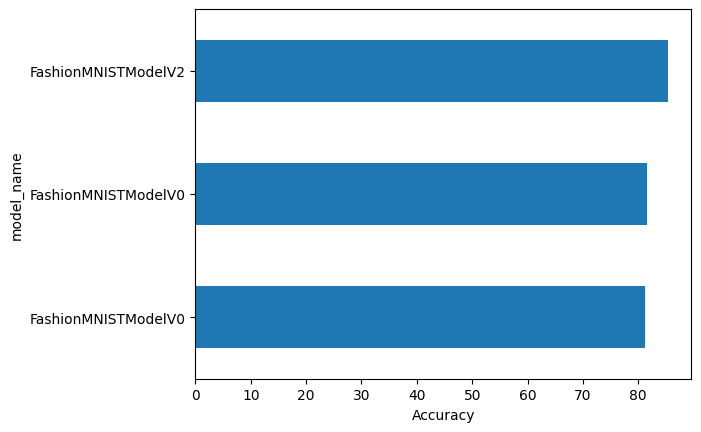

In [115]:
#Visualize our models
compare_results.set_index("model_name")["model_acc"].plot(kind='barh')
plt.xlabel("Accuracy")

In [130]:
# Make and evaluate random prediction with best model
def make_prediction(model,
                   data,
                   device=device):
    pred_probs =[]
    model.eval()
    with torch.inference_mode():
        for sample in data:
            #prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample,dim=0).to(device)
            #forward pass
            pred_logit = model(sample)
            #get pred_prob
            pred_prob = torch.softmax(pred_logit.squeeze(), dim =0)
            #get pred_prob aff the GPU for further calcualtions
            pred_probs.append(pred_prob.cpu())
        return torch.stack(pred_probs)

In [155]:
import random
random.seed(42)
test_samples =[]
test_labels =[]
for sample,label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

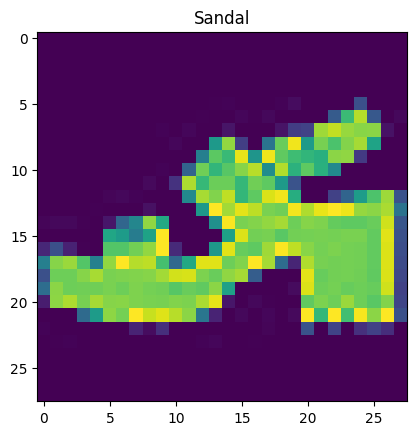

In [124]:
plt.imshow(test_samples[0].squeeze())
plt.title(class_names[test_labels[0]])

In [156]:
pred_probs = make_prediction(model=model_2, data=test_samples)

In [157]:
pred_classes =pred_probs.argmax(dim=1)

In [146]:
pred_classes,test_labels

(tensor([5, 1, 7, 2, 3, 0, 4, 7, 1]), [5, 1, 7, 4, 3, 0, 4, 7, 1])

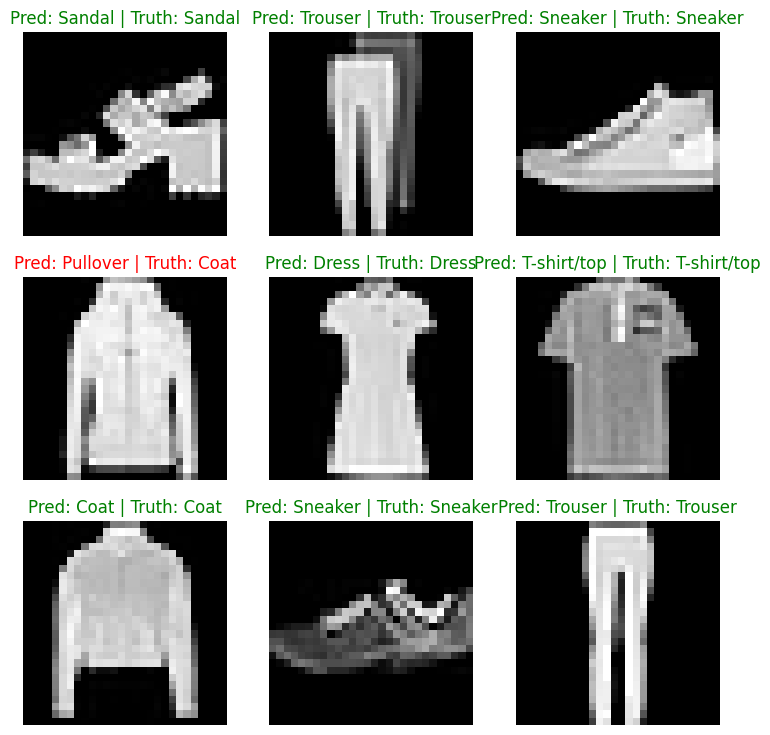

In [158]:
#Plot predictions
plt.figure(figsize=(9,9))
nrows =3
ncols =3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text  = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label==truth_label:
        plt.title(title_text, c='g')
    else:
        plt.title(title_text, c='r')
    plt.axis("off")

In [159]:
#Make predictiion on the whole test data
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc="Making predictions..."):
        # send the data to gpu
        X, y = X.to(device),y.to(device)
        # Do the forward pass
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim =0).argmax(dim =1)
        y_preds.append(y_pred.cpu())

y_preds = torch.cat(y_preds)

Making predictions...: 100%|████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 216.38it/s]


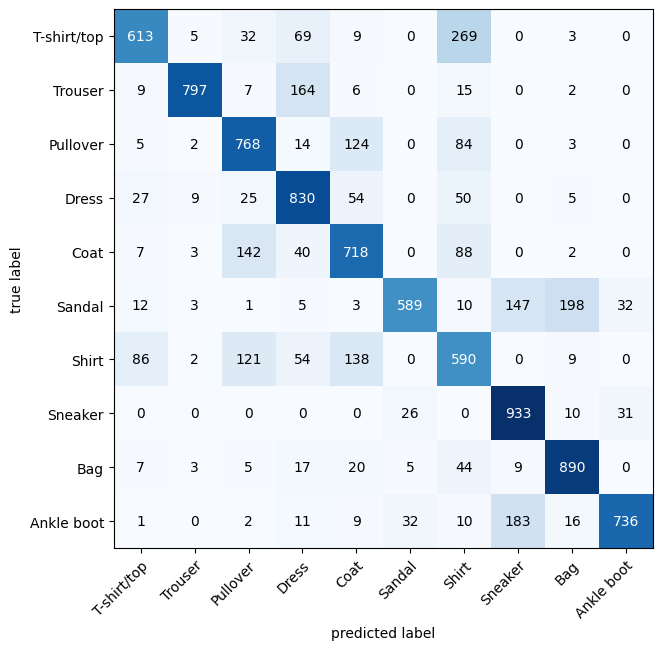

In [170]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes = len(class_names))
confmat_tensor = confmat(preds = y_preds,
                        target = test_data.targets)

#Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)

In [171]:
#Save and load best performing model
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents = True,
                exist_ok=True)

#Create model save
MODEL_NAME = 'FashionMNISTV02.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_2.state_dict(), MODEL_SAVE_PATH)

Saving model to: models\FashionMNISTV02.pth


In [172]:
#Create a new instance of model_2
loaded_model_2 = FashionMNISTModelV2(input_shape=1, output_shape=10,hidden_units=10)
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2.to(device)
loaded_model_2.state_dict()

C:\Users\dasdi\AppData\Local\Temp\ipykernel_2436\577691804.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-3.3660e-01,  1.1899e+00, -1.8674e-01],
                        [-2.0680e-01, -1.1905e+00, -1.8126e+00],
                        [-3.4546e-01, -4.8651e+00, -2.8792e+00]]],
              
              
                      [[[-6.9110e-01,  2.6331e-01, -8.8605e-02],
                        [-4.0334e-01,  1.3979e-01, -1.2387e-01],
                        [ 2.4934e-02, -6.8185e-03, -2.2131e-01]]],
              
              
                      [[[ 2.4777e-01,  1.5800e-01, -6.3153e-01],
                        [ 3.0567e-01,  3.2863e-02, -3.6445e-01],
                        [ 4.8569e-01, -6.3446e-01, -1.7215e-01]]],
              
              
                      [[[-2.8383e+00, -1.1294e+00, -8.5436e-02],
                        [-1.5387e-01,  3.9785e-01, -4.0131e-01],
                        [-1.1539e-01,  2.7390e-02, -1.9306e-01]]],
              
              
                      [[[ 2.2178e-01, -7.9653e-01,  4

In [173]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3961966931819916,
 'model_acc': 85.33346652984619}

In [175]:
loaded_model_2_results = eval_model(loaded_model_2,test_dataloader,loss_fn=loss_fn, accuracy_fn=accuracy)

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 165.39it/s]


In [178]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
             torch.tensor(loaded_model_2_results["model_loss"]),
             atol=1e-02)

tensor(True)